In [64]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
if not os.path.exists('../data/bank-full.csv'):
    !wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
    !unzip bank+marketing.zip

df = pd.read_csv('../data/bank-full.csv', sep=';')
df.head()

df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [66]:
# Select only the specified features
selected_features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[selected_features]

# Display the first few rows of the processed dataset
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [67]:
# Check for missing values
print(df.isnull().sum())

if df.isnull().sum().sum() == 0:
    print("No missing values")

print(df.head())


age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
No missing values
   age           job  marital  education  balance housing  contact  day month  \
0   58    management  married   tertiary     2143     yes  unknown    5   may   
1   44    technician   single  secondary       29     yes  unknown    5   may   
2   33  entrepreneur  married  secondary        2     yes  unknown    5   may   
3   47   blue-collar  married    unknown     1506     yes  unknown    5   may   
4   33       unknown   single    unknown        1      no  unknown    5   may   

   duration  campaign  pdays  previous poutcome   y  
0       261         1     -1         0  unknown  no  
1       151         1     -1         0  unknown  no  
2        76         1     -1         0  unknown  no  
3        92         1     -1         0  u

Mode of 'education': secondary


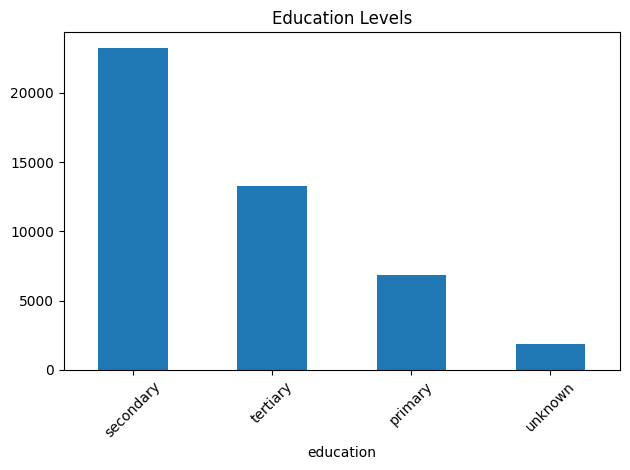

In [68]:
education_mode = df['education'].mode()[0]
print(f"Mode of 'education': {education_mode}")

# Quick bar plot of education levels
df['education'].value_counts().plot(kind='bar')
plt.title('Education Levels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


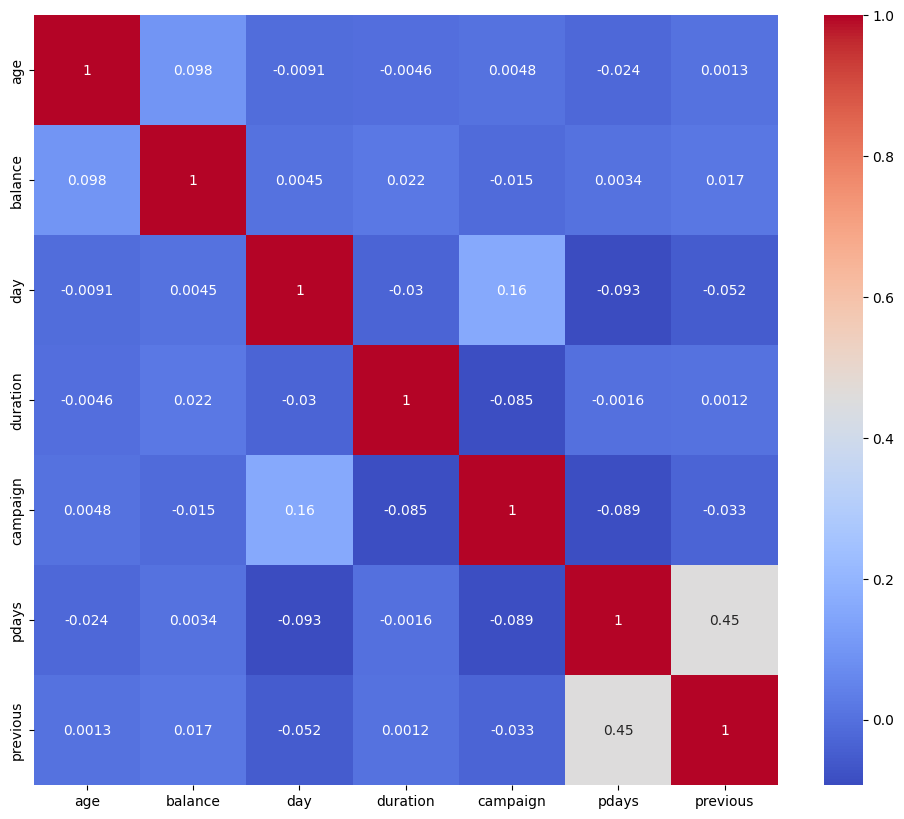

In [69]:
num_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
corr_matrix = df[num_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

highest_corr = corr_matrix.unstack().sort_values(key=abs, ascending=False)
highest_corr = highest_corr[highest_corr.index.get_level_values(0) != highest_corr.index.get_level_values(1)].iloc[0]


In [70]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})

X = df.drop('y', axis=1)
y = df['y']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")



X_train: (27126, 14), X_val: (9042, 14), X_test: (9043, 14)


In [71]:
categorical_features = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

mi_scores = {}
for feature in categorical_features:
    mi_score = mutual_info_score(y_train, X_train[feature])
    mi_scores[feature] = round(mi_score, 2)

sorted_mi_scores = sorted(mi_scores.items(), key=lambda x: x[1], reverse=True)

print("Mutual Information Scores:")
for feature, score in sorted_mi_scores:
    print(f"{feature}: {score}")


Mutual Information Scores:
poutcome: 0.03
month: 0.02
job: 0.01
housing: 0.01
contact: 0.01
marital: 0.0
education: 0.0


In [76]:
cat_features = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']
X_train_enc = pd.get_dummies(X_train, columns=cat_features)
X_val_enc = pd.get_dummies(X_val, columns=cat_features).reindex(columns=X_train_enc.columns, fill_value=0)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train_enc, y_train)

acc = round(accuracy_score(y_val, model.predict(X_val_enc)), 2)
print(f"Val accuracy: {acc}")


Val accuracy: 0.9


In [77]:
all_features = X_train.columns.tolist()

model_all = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
X_train_encoded_all = pd.get_dummies(X_train, columns=categorical_features)
X_val_encoded_all = pd.get_dummies(X_val, columns=categorical_features).reindex(columns=X_train_encoded_all.columns, fill_value=0)
model_all.fit(X_train_encoded_all, y_train)
accuracy_all = accuracy_score(y_val, model_all.predict(X_val_encoded_all))

accuracy_diff = {}

for feature in all_features:
    features_without = [f for f in all_features if f != feature]
    
    X_train_subset = X_train[features_without]
    X_val_subset = X_val[features_without]
    
    cat_subset = [f for f in categorical_features if f != feature]
    X_train_encoded = pd.get_dummies(X_train_subset, columns=cat_subset)
    X_val_encoded = pd.get_dummies(X_val_subset, columns=cat_subset).reindex(columns=X_train_encoded.columns, fill_value=0)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train_encoded, y_train)
    
    accuracy = accuracy_score(y_val, model.predict(X_val_encoded))
    accuracy_diff[feature] = accuracy_all - accuracy

least_useful = min(accuracy_diff, key=accuracy_diff.get)

print(f"Least useful: {least_useful}, diff: {accuracy_diff[least_useful]:.4f}")

for f in ['age', 'balance', 'marital', 'previous']:
    print(f"{f} diff: {accuracy_diff[f]:.4f}")


Least useful: housing, diff: -0.0012
age diff: 0.0004
balance diff: 0.0001
marital diff: -0.0006
previous diff: 0.0003


In [78]:
C_values = [0.01, 0.1, 1, 10, 100]
accuracies = {}

X_train_enc = pd.get_dummies(X_train, columns=categorical_features)
X_val_enc = pd.get_dummies(X_val, columns=categorical_features).reindex(columns=X_train_enc.columns, fill_value=0)

for C in C_values:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train_enc, y_train)
    accuracies[C] = round(accuracy_score(y_val, model.predict(X_val_enc)), 3)

best_C = max(accuracies, key=accuracies.get)
print(accuracies)
print(f"Best C: {best_C}, accuracy: {accuracies[best_C]}")


{0.01: 0.899, 0.1: 0.9, 1: 0.901, 10: 0.901, 100: 0.901}
Best C: 1, accuracy: 0.901


In [79]:
X_train.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
6377,45,entrepreneur,married,primary,-100,yes,unknown,27,may,240,6,-1,0,unknown
17236,29,services,single,secondary,166,no,cellular,28,jul,108,8,-1,0,unknown
4490,31,admin.,single,secondary,121,yes,unknown,20,may,187,1,-1,0,unknown
24231,40,self-employed,single,tertiary,1693,yes,cellular,17,nov,353,1,-1,0,unknown
3978,28,services,single,secondary,317,yes,unknown,16,may,21,3,-1,0,unknown
